In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "fer2013-dataset-images"

# EmotionTrack Tutor Image classification project
## Problem definition
The objective of this project is to develop a Semi-Structured Distributional Regression (SSMR) model capable of detecting and classifying a user's emotion into Paul Ekman’s Six Universal Emotions: Anger, Disgust, Enjoyment, Fear, Sadness, and Surprise. This model will be integrated into the EmotionTrack Tutor app, an educational platform designed for Android devices that utilizes virtual reality (VR) environments. The app aims to engage users emotionally during their learning process through interactive simulations, while reducing the effects of the uncanny valley—a phenomenon where human-like avatars evoke discomfort due to subtle imperfections in realism.

## Data
The data used in training this model is sourced from kaggle(https://www.kaggle.com/datasets/damnithurts/fer2013-dataset-images). The folder contains train and test folder in which the train set was used to train the models and test was used to test the model

## Evaluation
in this project loss and accuracy were used to evaluate how the models performed
## Features
In each train and test folder contained subfolder contain images of each Paul Ekman’s Six Universal Emotions: Anger, Disgust, Enjoyment, Fear, Sadness, and Surprise.

In [2]:
# List of required libraries
required_libraries <- c(
"tidymodels","readr","keras","tensorflow","reticulate"
)

#Import the packages
library(tidymodels)
library(readr)
library(keras)
library(tensorflow)
library(reticulate)

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.4.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages


Attaching package: ‘keras’


The following object is masked from ‘package:yardstick’:

    get_weights




In [3]:
set.seed(231)

In [4]:
original_dataset_dir <- "/kaggle/input/fer2013-dataset-images"
base_dir <- "/kaggle/working/emotion_images_app"
dir.create(base_dir)

In [5]:
# Create train, validation  and test directories
train_dir <- file.path(base_dir, "train")
dir.create(train_dir)
validation_dir <- file.path(base_dir, "validation")
dir.create(validation_dir)
test_dir <- file.path(base_dir, "test")
dir.create(test_dir)

In [6]:
#Create emotion-specific directories for train, validation and test sets
emotion_categories <- c("angry", "disgust", "fear", "happy", "neutral", "sad", "surprise")

In [7]:
for (emotion in emotion_categories) {
  train_emotion_dir <- file.path(train_dir, emotion)
  dir.create(train_emotion_dir)
  
  validation_emotion_dir <- file.path(validation_dir, emotion)
  dir.create(validation_emotion_dir)
  
  
  test_emotion_dir <- file.path(test_dir, emotion)
  dir.create(test_emotion_dir)
}

In [8]:
# Function to copy files from original directory to new directories based on the split
copy_images <- function(emotion, split_ratio = 0.8) {
  # List all files for a given emotion
  emotion_train_files <- list.files(file.path(original_dataset_dir, "train", emotion), full.names = TRUE)
  emotion_test_files <- list.files(file.path(original_dataset_dir, "test", emotion), full.names = TRUE)
  
  # Define the split for training and validation
  n_train <- length(emotion_train_files)
  n_validation <- as.integer(n_train * (1 - split_ratio))
  
  # Train and validation split
  validation_files <- emotion_train_files[1:n_validation]
  train_files <- emotion_train_files[(n_validation + 1):n_train]
  
  # Copy training files
  file.copy(train_files, file.path(train_dir, emotion))
  
  # Copy validation files
  file.copy(validation_files, file.path(validation_dir, emotion))
  
  # Copy test files
  file.copy(emotion_test_files, file.path(test_dir, emotion))
}

In [9]:
# Loop over emotion categories and copy images accordingly
for (emotion in emotion_categories) {
  copy_images(emotion)
}


In [10]:
# Display the number of images in each directory
for (emotion in emotion_categories) {
  cat("total training", emotion, "images:", length(list.files(file.path(train_dir, emotion))), "\n")
  cat("total validation", emotion, "images:", length(list.files(file.path(validation_dir, emotion))), "\n")
  cat("total test", emotion, "images:", length(list.files(file.path(test_dir, emotion))), "\n")
}

total training angry images: 3197 
total validation angry images: 798 
total test angry images: 958 
total training disgust images: 349 
total validation disgust images: 87 
total test disgust images: 111 
total training fear images: 3278 
total validation fear images: 819 
total test fear images: 1024 
total training happy images: 5773 
total validation happy images: 1442 
total test happy images: 1774 
total training neutral images: 3973 
total validation neutral images: 992 
total test neutral images: 1233 
total training sad images: 3865 
total validation sad images: 965 
total test sad images: 1247 
total training surprise images: 2537 
total validation surprise images: 634 
total test surprise images: 831 


In [11]:
model <- keras_model_sequential() %>%
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu",
                input_shape = c(150, 150, 1)) %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_flatten() %>%
  layer_dense(units = 512, activation = "relu") %>%
  layer_dense(units = 7, activation = "softmax") 

summary(model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_3 (Conv2D)                  (None, 148, 148, 32)            320         
 max_pooling2d_3 (MaxPooling2D)     (None, 74, 74, 32)              0           
 conv2d_2 (Conv2D)                  (None, 72, 72, 64)              18496       
 max_pooling2d_2 (MaxPooling2D)     (None, 36, 36, 64)              0           
 conv2d_1 (Conv2D)                  (None, 34, 34, 128)             73856       
 max_pooling2d_1 (MaxPooling2D)     (None, 17, 17, 128)             0           
 conv2d (Conv2D)                    (None, 15, 15, 128)             147584      
 max_pooling2d (MaxPooling2D)       (None, 7, 7, 128)               0           
 flatten (Flatten)                  (None, 6272)                    0           
 dense_1 (Dense)                    (None, 512)                     3211776     
 dense (

In [12]:
model %>% compile(
  loss = "categorical_crossentropy",  
  optimizer = optimizer_rmsprop(lr = 1e-4),
  metrics = c("accuracy") 
)


## Data preprocessing

In [13]:
# Using image_data_generator to read images from directories
train_datagen <- image_data_generator(rescale = 1/255)
validation_datagen <- image_data_generator(rescale = 1/255)

train_generator <- flow_images_from_directory(
  "/kaggle/working/emotion_images_app/train",  
  train_datagen,
  target_size = c(150, 150),
  batch_size = 20,
  class_mode = "categorical",  
  color_mode = "grayscale"   
)

validation_generator <- flow_images_from_directory(
  "/kaggle/working/emotion_images_app/validation", 
  validation_datagen,
  target_size = c(150, 150),
  batch_size = 20,
  class_mode = "categorical",
  color_mode = "grayscale"   
)


In [14]:
#Displaying a batch of data and labels
batch <- generator_next(train_generator)
str(batch)

List of 2
 $ : num [1:20, 1:150, 1:150, 1] 0.1608 0.0431 0.3255 0.4706 0.0235 ...
 $ : num [1:20, 1:7] 1 1 0 1 1 1 0 0 0 1 ...


In [15]:
history <- model %>% fit(
  train_generator,
  steps_per_epoch = 100,
  epochs = 30,
  validation_data = validation_generator,
  validation_steps = 50
)

In [16]:
#Saving the model
model %>% save_model_hdf5("first_model.h5")

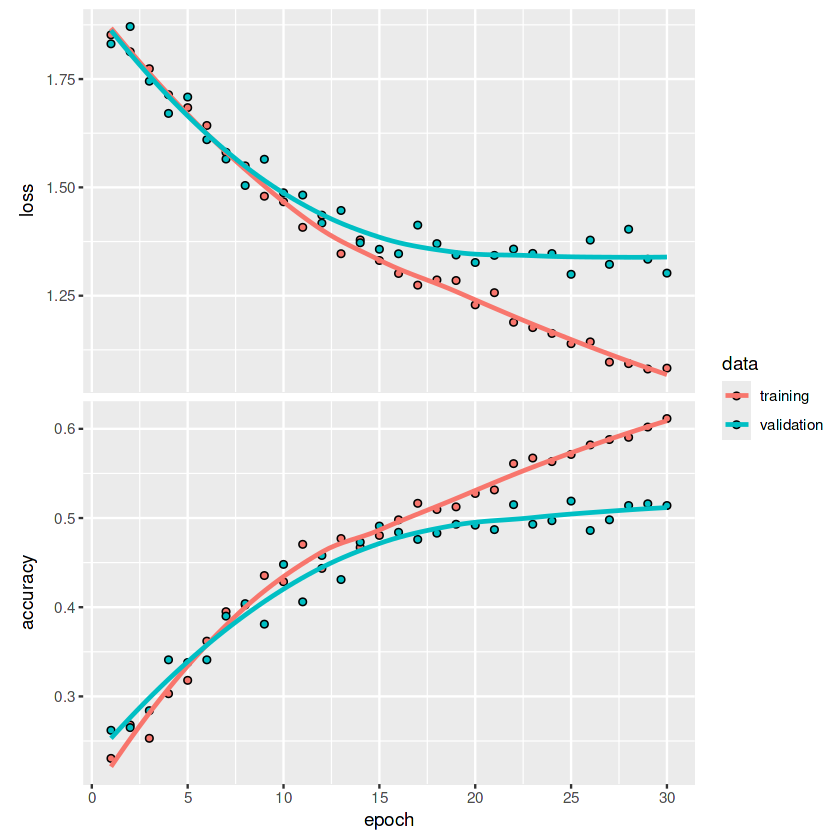

In [17]:
# Displaying curves of loss and accuracy during training
plot(history)

### OBSERVATION
The plots demonstrates that both training and validation loss steadily decrease while accuracy increases over the epochs, indicating that the model is learning effectively. However, the widening gap between training and validation performance, with training loss decreasing more rapidly and training accuracy increasing faster, suggests the model may be overfitting as it performs better on the training data compared to the validation data.

## data augmentation

In [18]:
#Setting up a data augmentation configuration via image_data_generator
#datagen <- image_data_generator(
#rescale = 1/255,
#rotation_range = 40,
#width_shift_range = 0.2,
#height_shift_range = 0.2,
#shear_range = 0.2,
#zoom_range = 0.2,
#horizontal_flip = TRUE,
#fill_mode = "nearest"
#)

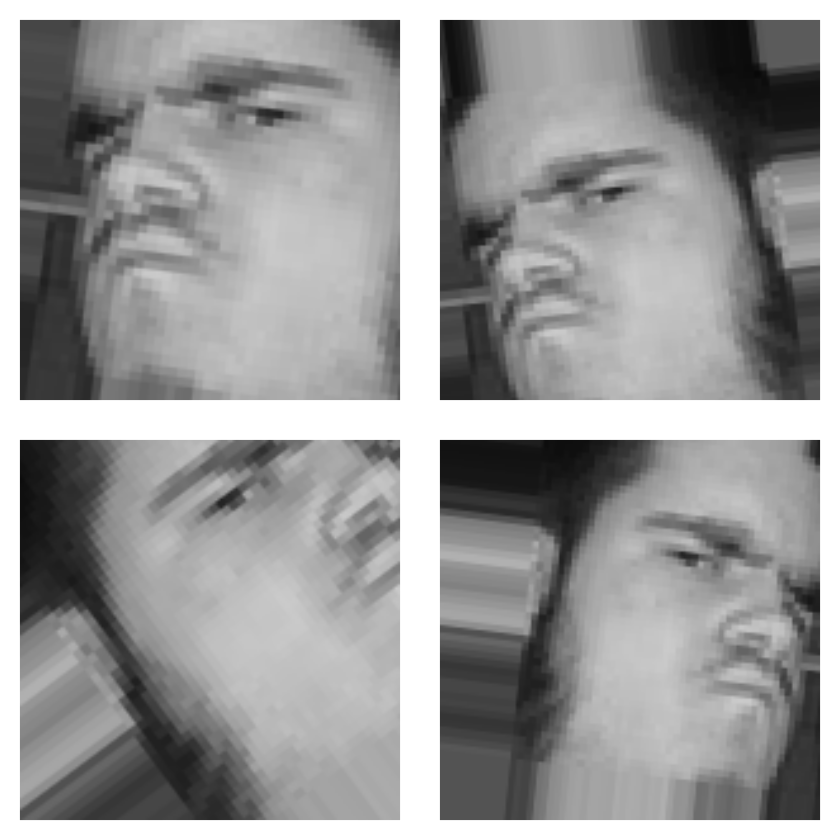

In [19]:
fnames <- list.files("/kaggle/working/emotion_images_app/train/angry", full.names = TRUE)  

img_path <- fnames[[3]] 
img <- image_load(img_path, target_size = c(150, 150), grayscale = TRUE)  

img_array <- image_to_array(img)
img_array <- img_array / 255 
img_array <- array_reshape(img_array, c(1, 150, 150, 1))  

datagen <- image_data_generator(
  rotation_range = 40,      
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = TRUE,
  fill_mode = "nearest"
)

augmentation_generator <- flow_images_from_data(
  img_array,
  generator = datagen,
  batch_size = 1
)

op <- par(mfrow = c(2, 2), pty = "s", mar = c(1, 0, 1, 0))

for (i in 1:4) {
  batch <- generator_next(augmentation_generator)
  plot(as.raster(batch[1,,,], col = grey.colors(256))) 
}

par(op)


In [20]:
# Defining a new convnet that includes dropout
model <- keras_model_sequential() %>%
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu",
                input_shape = c(150, 150, 3)) %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_flatten() %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 512, activation = "relu") %>%
  layer_dense(units = 7, activation = "softmax") 

# Compiling the model
model %>% compile(
  loss = "categorical_crossentropy", 
  optimizer = optimizer_rmsprop(lr = 1e-4), 
  metrics = c("accuracy") 
)

In [21]:
# Image data augmentation for training
#datagen <- image_data_generator(
#  rescale = 1/255,
#  rotation_range = 40,
#  width_shift_range = 0.2,
#  height_shift_range = 0.2,
#  shear_range = 0.2,
#  zoom_range = 0.2,
#  horizontal_flip = TRUE
#)

test_datagen <- image_data_generator(rescale = 1/255)

In [22]:
train_generator <- flow_images_from_directory(
  train_dir,
  datagen,
  target_size = c(150, 150), 
  batch_size = 32, 
  class_mode = "categorical" 
)

In [23]:
validation_generator <- flow_images_from_directory(
  validation_dir,
  test_datagen,
  target_size = c(150, 150),
  batch_size = 32,
  class_mode = "categorical"
)


In [30]:
history <- model %>% fit(
  train_generator,
  steps_per_epoch = 50,    
  epochs = 20,            
  validation_data = validation_generator,
  validation_steps = 20    
)
history


Final epoch (plot to see history):
        loss: 1.808
    accuracy: 0.2537
    val_loss: 1.807
val_accuracy: 0.2516 

In [31]:
summary(model)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_7 (Conv2D)                  (None, 148, 148, 32)            896         
 max_pooling2d_7 (MaxPooling2D)     (None, 74, 74, 32)              0           
 conv2d_6 (Conv2D)                  (None, 72, 72, 64)              18496       
 max_pooling2d_6 (MaxPooling2D)     (None, 36, 36, 64)              0           
 conv2d_5 (Conv2D)                  (None, 34, 34, 128)             73856       
 max_pooling2d_5 (MaxPooling2D)     (None, 17, 17, 128)             0           
 conv2d_4 (Conv2D)                  (None, 15, 15, 128)             147584      
 max_pooling2d_4 (MaxPooling2D)     (None, 7, 7, 128)               0           
 flatten_1 (Flatten)                (None, 6272)                    0           
 dropout (Dropout)                  (None, 6272)                    0           
 dense

In [32]:
#Saving the model
model %>% save_model_hdf5("second_model.h5")

## Using a pretrained convnet
##  Feature extraction


In [33]:
#Instantiating the VGG16 convolutional base
conv_base <- application_vgg16(
weights = "imagenet",
include_top = FALSE,
input_shape = c(150, 150, 3)
)

conv_base

Model: "vgg16"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_2 (InputLayer)               [(None, 150, 150, 3)]           0           
 block1_conv1 (Conv2D)              (None, 150, 150, 64)            1792        
 block1_conv2 (Conv2D)              (None, 150, 150, 64)            36928       
 block1_pool (MaxPooling2D)         (None, 75, 75, 64)              0           
 block2_conv1 (Conv2D)              (None, 75, 75, 128)             73856       
 block2_conv2 (Conv2D)              (None, 75, 75, 128)             147584      
 block2_pool (MaxPooling2D)         (None, 37, 37, 128)             0           
 block3_conv1 (Conv2D)              (None, 37, 37, 256)             295168      
 block3_conv2 (Conv2D)              (None, 37, 37, 256)             590080      
 block3_conv3 (Conv2D)              (None, 37, 37, 256)             590080      
 block3_pool 

In [35]:
# Extracting features using the pretrained convolutional base

#base_dir <- "/kaggle/working/emotion_images_app"
#train_dir <- file.path(base_dir, "train")
#validation_dir <- file.path(base_dir, "validation")
#test_dir <- file.path(base_dir, "test")


#datagen <- image_data_generator(rescale = 1/255)

batch_size <- 20

extract_features <- function(directory, sample_count) {
  features <- array(0, dim = c(sample_count, 4, 4, 512))
  labels <- array(0, dim = c(sample_count, length(list.files(directory))))

  
  generator <- flow_images_from_directory(
    directory = directory,
    generator = datagen,
    target_size = c(150, 150),  
    batch_size = batch_size,
    class_mode = "categorical" 
  )

  i <- 0
  while (TRUE) {
    batch <- generator_next(generator)
    inputs_batch <- batch[[1]] 
    labels_batch <- batch[[2]]  
    
    features_batch <- conv_base %>% predict(inputs_batch)
    
    index_range <- ((i * batch_size) + 1):min(((i + 1) * batch_size), sample_count)
    
    features[index_range,,,] <- features_batch
    labels[index_range,] <- labels_batch  
    
    i <- i + 1
    if (i * batch_size >= sample_count)
      break
  }
  
  list(
    features = features,
    labels = labels
  )
}


train <- extract_features(train_dir, 14000)      
validation <- extract_features(validation_dir, 5000) 
test <- extract_features(test_dir, 6000)       


In [36]:
#flatten them
reshape_features <- function(features) {
array_reshape(features, dim = c(nrow(features), 4 * 4 * 512))
}
train$features <- reshape_features(train$features)
validation$features <- reshape_features(validation$features)
test$features <- reshape_features(test$features)

In [37]:
# Defining and training the densely connected classifier
num_classes <- length(list.files(train_dir))  

model <- keras_model_sequential() %>%
  layer_dense(units = 256, activation = "relu", input_shape = 4 * 4 * 512) %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = num_classes, activation = "softmax") 

model %>% compile(
  optimizer = optimizer_rmsprop(lr = 2e-5),
  loss = "categorical_crossentropy", 
  metrics = c("accuracy")
)

history <- model %>% fit(
  train$features, train$labels,
  epochs = 30,
  batch_size = 20,
  validation_data = list(validation$features, validation$labels)
)


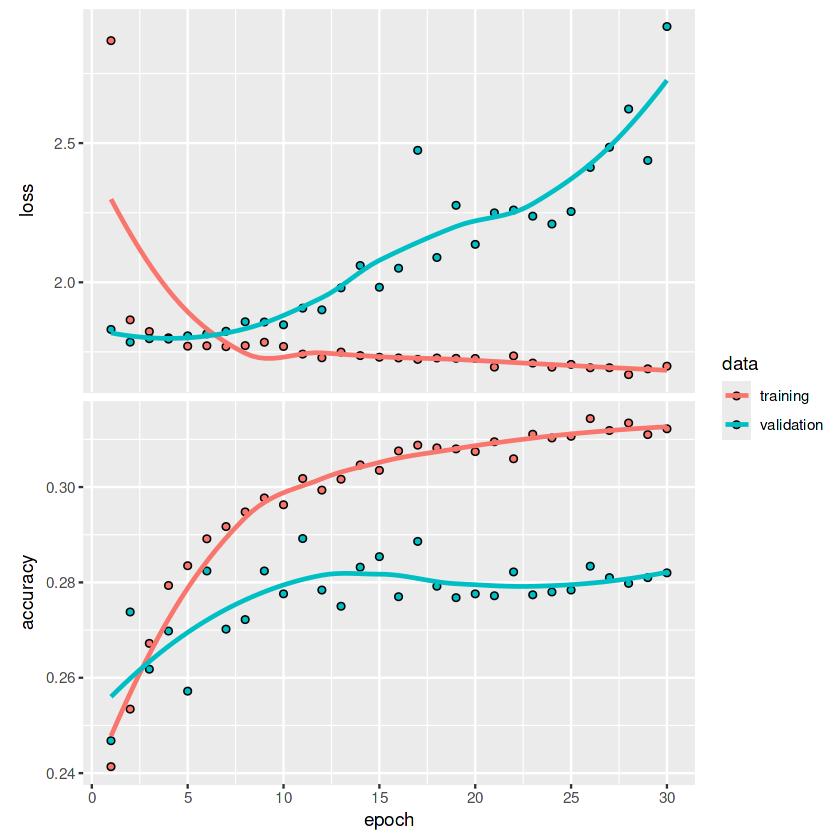

In [38]:
#Plotting the results
plot(history)

### OBSERVATION
The plot shows that regularization techniques:data augmentation and dropout done above  have effectively minimized overfitting. The training loss steadily decreases, while the validation loss remains stable without a significant increase, indicating improved generalization to unseen data. Similarly, while training accuracy rises sharply, validation accuracy improves gradually, maintaining a controlled gap, which suggests that the model isn't overfitting to the training data. 

### FEATURE EXTRACTION WITH DATA AUGMENTATION


In [39]:
# Adding a densely connected classifier on top of the convolutional base
model <- keras_model_sequential() %>%
  conv_base %>%
  layer_flatten() %>%
  layer_dense(units = 256, activation = "relu") %>%
  layer_dense(units = 7, activation = "softmax")  


model

Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 vgg16 (Functional)                 (None, 4, 4, 512)               14714688    
 flatten_2 (Flatten)                (None, 8192)                    0           
 dense_7 (Dense)                    (None, 256)                     2097408     
 dense_6 (Dense)                    (None, 7)                       1799        
Total params: 16,813,895
Trainable params: 16,813,895
Non-trainable params: 0
________________________________________________________________________________

In [40]:
#freeze a network
cat("This is the number of trainable weights before freezing",
"the conv base:", length(model$trainable_weights), "\n")

freeze_weights(conv_base)


cat("This is the number of trainable weights after freezing",
"the conv base:", length(model$trainable_weights), "\n")

This is the number of trainable weights before freezing the conv base: 30 
This is the number of trainable weights after freezing the conv base: 4 


In [41]:
# Data Augmentation for Training 
train_datagen <- image_data_generator(
  rescale = 1/255,
  rotation_range = 20,             
  width_shift_range = 0.1,         
  height_shift_range = 0.1,        
  shear_range = 0.1,               
  zoom_range = 0.1,                
  horizontal_flip = TRUE,
  fill_mode = "nearest"
)

# Test Data Generator
test_datagen <- image_data_generator(rescale = 1/255)

In [42]:
# Creating Generators
train_generator <- flow_images_from_directory(
  train_dir,
  train_datagen,
  target_size = c(128, 128),       
  batch_size = 32,                
  class_mode = "categorical"
)


In [43]:
validation_generator <- flow_images_from_directory(
  validation_dir,
  test_datagen,
  target_size = c(128, 128),       
  batch_size = 32,               
  class_mode = "categorical"
)

In [44]:
# Compiling the Model 
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_rmsprop(lr = 1e-4),  
  metrics = c("accuracy")
)
model

Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                  Output Shape               Param #    Trainable  
 vgg16 (Functional)            (None, 4, 4, 512)          14714688   N          
 flatten_2 (Flatten)           (None, 8192)               0          Y          
 dense_7 (Dense)               (None, 256)                2097408    Y          
 dense_6 (Dense)               (None, 7)                  1799       Y          
Total params: 16,813,895
Trainable params: 2,099,207
Non-trainable params: 14,714,688
________________________________________________________________________________

In [45]:
# Fitting the Model
history <- model %>% fit(
  train_generator,
  steps_per_epoch = ceiling(train_generator$n / train_generator$batch_size),
  epochs = 20,                    
  validation_data = validation_generator,
  validation_steps = ceiling(validation_generator$n / validation_generator$batch_size)
)
history


Final epoch (plot to see history):
        loss: 1.231
    accuracy: 0.538
    val_loss: 1.309
val_accuracy: 0.5163 

In [ ]:
plot(history)

### Fine-tuning

In [46]:
#Unfreezing previously frozen layers
unfreeze_weights(conv_base, from = "block5_conv1")

In [47]:
# Fine-tuning the model
learning_rate <- 1e-5
batch_size <- 32 
dropout_rate <- 0.5  
steps_per_epoch <- ceiling(length(train_generator) / batch_size)
validation_steps <- ceiling(length(validation_generator) / batch_size)

model %>% compile(
  loss = "categorical_crossentropy",  
  optimizer = optimizer_rmsprop(lr = learning_rate),
  metrics = c("accuracy")
)


callbacks <- list(
  callback_early_stopping(monitor = "val_loss", patience = 10, restore_best_weights = TRUE),
  callback_reduce_lr_on_plateau(monitor = "val_loss", factor = 0.5, patience = 5)
)

history <- model %>% fit(
  train_generator,
  steps_per_epoch = steps_per_epoch,
  epochs = 100,
  validation_data = validation_generator,
  validation_steps = validation_steps,
  batch_size = batch_size,
  callbacks = callbacks
)
history


Final epoch (plot to see history):
        loss: 1.207
    accuracy: 0.5448
    val_loss: 1.282
val_accuracy: 0.5104
          lr: 0.0000625 

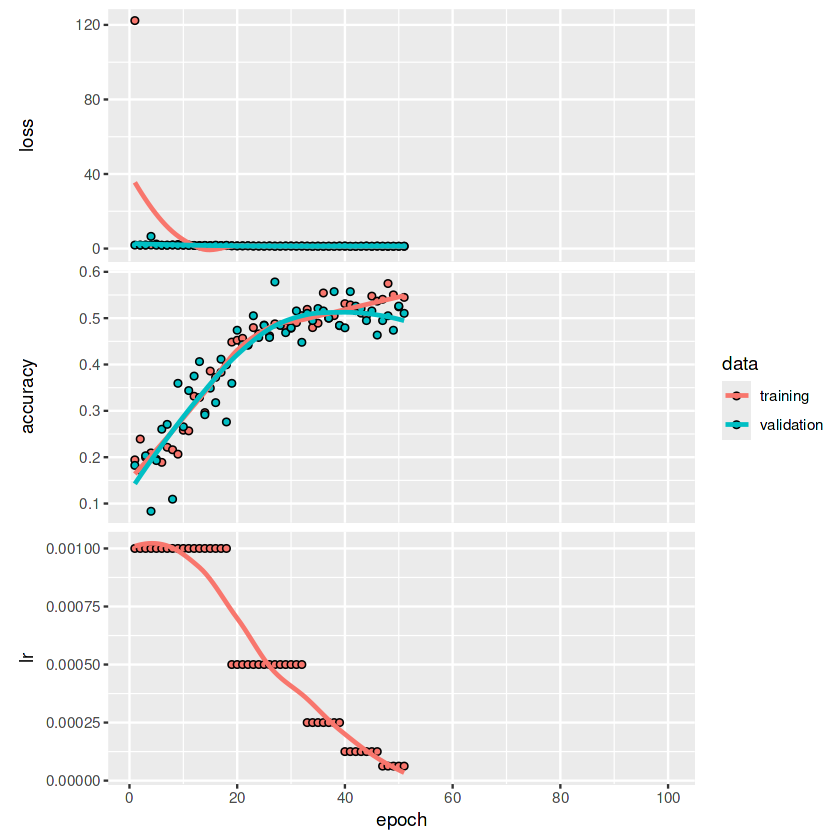

In [50]:
plot(history)

## valuate this model on the test data

In [48]:
test_generator <- flow_images_from_directory(
test_dir,
test_datagen,
target_size = c(150, 150),
batch_size = 20,
class_mode = "categorical"
)

model %>% evaluate(test_generator, steps = 50)

loss accuracy 
1.354179 0.473000

In [51]:
#Visualizing intermediate activations
model <- load_model_hdf5("second_model.h5")
model


Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_7 (Conv2D)                  (None, 148, 148, 32)            896         
 max_pooling2d_7 (MaxPooling2D)     (None, 74, 74, 32)              0           
 conv2d_6 (Conv2D)                  (None, 72, 72, 64)              18496       
 max_pooling2d_6 (MaxPooling2D)     (None, 36, 36, 64)              0           
 conv2d_5 (Conv2D)                  (None, 34, 34, 128)             73856       
 max_pooling2d_5 (MaxPooling2D)     (None, 17, 17, 128)             0           
 conv2d_4 (Conv2D)                  (None, 15, 15, 128)             147584      
 max_pooling2d_4 (MaxPooling2D)     (None, 7, 7, 128)               0           
 flatten_1 (Flatten)                (None, 6272)                    0           
 dropout (Dropout)                  (None, 6272)                    0           
 dense

In [52]:
#Preprocessing a single image

img_path <- "/kaggle/input/fer2013-dataset-images/test/angry/PrivateTest_24606826.jpg"
img <- image_load(img_path, target_size = c(150, 150))
img_tensor <- image_to_array(img)
img_tensor <- array_reshape(img_tensor, c(1, 150, 150, 3))
img_tensor <- img_tensor / 255
dim(img_tensor)


[1]   1 150 150   3

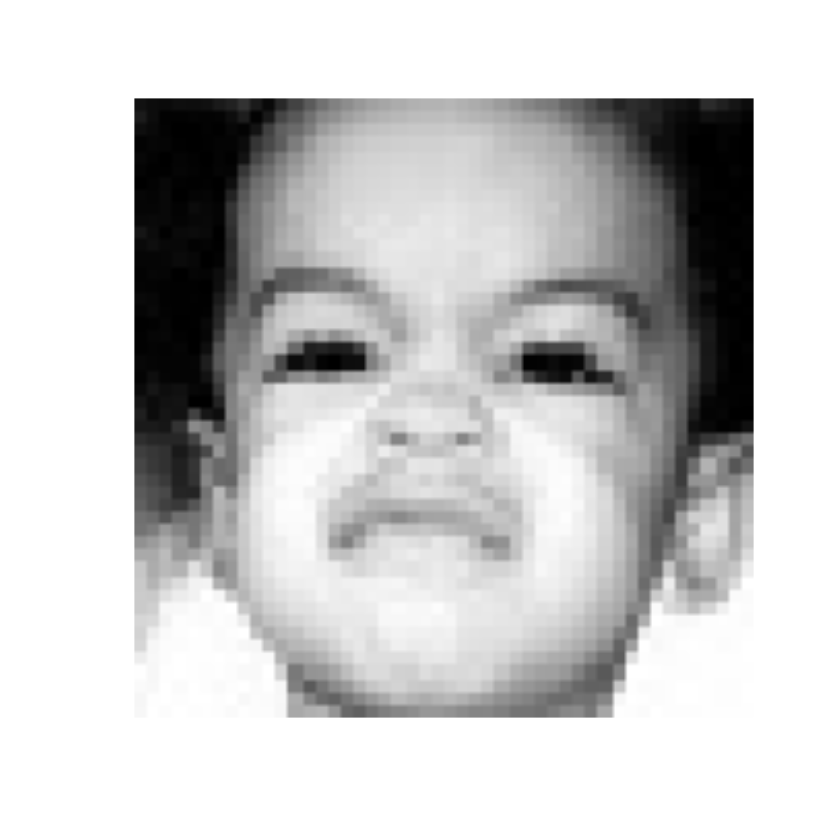

In [53]:
#Displaying the test picture
plot(as.raster(img_tensor[1,,,]))

In [54]:
#Instantiating a model from an input tensor and a list of output tensors
layer_outputs <- lapply(model$layers[1:8], function(layer) layer$output)
activation_model <- keras_model(inputs = model$input, outputs = layer_outputs)

In [55]:
activations <- activation_model %>% predict(img_tensor)

In [56]:
first_layer_activation <- activations[[1]]
dim(first_layer_activation)

[1]   1 148 148  32

In [57]:
#Running the model in predict mode
plot_channel <- function(channel) {
rotate <- function(x) t(apply(x, 2, rev))
image(rotate(channel), axes = FALSE, asp = 1,
col = terrain.colors(12))
}


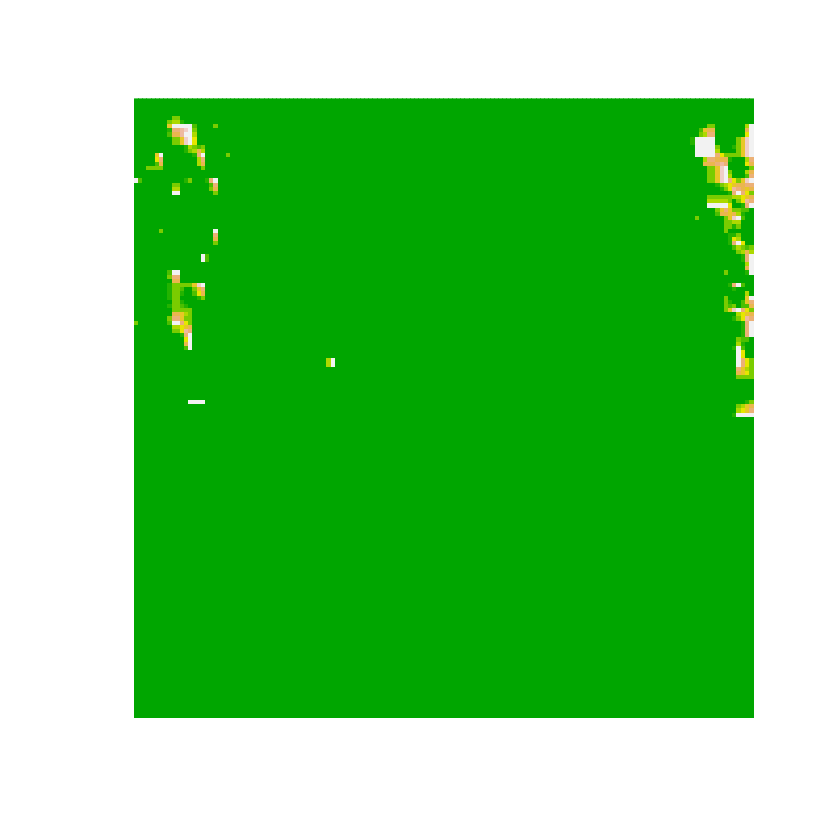

In [58]:
#Plotting the 2nd channel of the activation of the first layer of the original model
plot_channel(first_layer_activation[1,,,2])

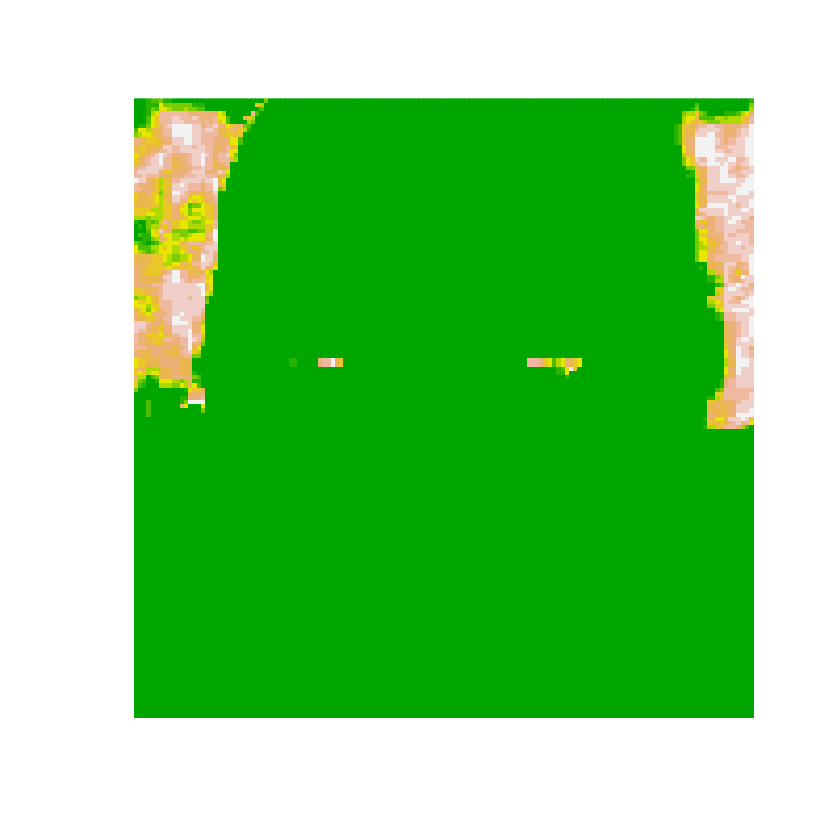

In [59]:
#Visualizing the seventh channel
plot_channel(first_layer_activation[1,,,7])

## Implementing a Structured Discriminative Representation (SSDR) model based on  existing CNN


In [60]:
# Load the previously trained CNN model
cnn_model <- load_model_hdf5("second_model.h5")

In [108]:
# unstructured input
input_unstructured <- layer_input(shape = c(150, 150, 1), name = "unstructured_input")

# Unstructured DNN for grayscale image input
unstructured_dnn <- input_unstructured %>%
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_flatten(name = "unstructured_flatten")

# latent features
latent_features <- unstructured_dnn %>%
  layer_dense(units = 256, activation = "relu", name = "latent_features")

# Distributional layer
distributional_output <- latent_features %>%
  layer_dense(units = 7, activation = "softmax", name = "distributional_output")

# ssdr model
ssdr_model <- keras_model(inputs = input_unstructured, outputs = distributional_output)

# Compile the model 
ssdr_model %>% compile(
  optimizer = optimizer_adam(),
  loss = "categorical_crossentropy",  
  metrics = list("accuracy")
)


summary(ssdr_model)


Model: "model_10"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 unstructured_input (InputLayer)    [(None, 150, 150, 1)]           0           
 conv2d_37 (Conv2D)                 (None, 148, 148, 32)            320         
 max_pooling2d_37 (MaxPooling2D)    (None, 74, 74, 32)              0           
 conv2d_36 (Conv2D)                 (None, 72, 72, 64)              18496       
 max_pooling2d_36 (MaxPooling2D)    (None, 36, 36, 64)              0           
 conv2d_35 (Conv2D)                 (None, 34, 34, 128)             73856       
 max_pooling2d_35 (MaxPooling2D)    (None, 17, 17, 128)             0           
 unstructured_flatten (Flatten)     (None, 36992)                   0           
 latent_features (Dense)            (None, 256)                     9470208     
 distributional_output (Dense)      (None, 7)                       1799        
Total para

In [109]:
train_generator <- flow_images_from_directory(
  train_dir,
  train_datagen,
  target_size = c(150, 150),
  batch_size = 32,
  class_mode = "categorical",
  color_mode = "grayscale"
)

In [110]:
validation_generator <- flow_images_from_directory(
  validation_dir,
  validation_datagen,
  target_size = c(150, 150),
  batch_size = 32,
  class_mode = "categorical",
  color_mode = "grayscale"
)


In [111]:
history_ssdr <- ssdr_model %>% fit(
  train_generator,
  steps_per_epoch = 50,
  epochs = 20,
  validation_data = validation_generator,
  validation_steps = 50
)


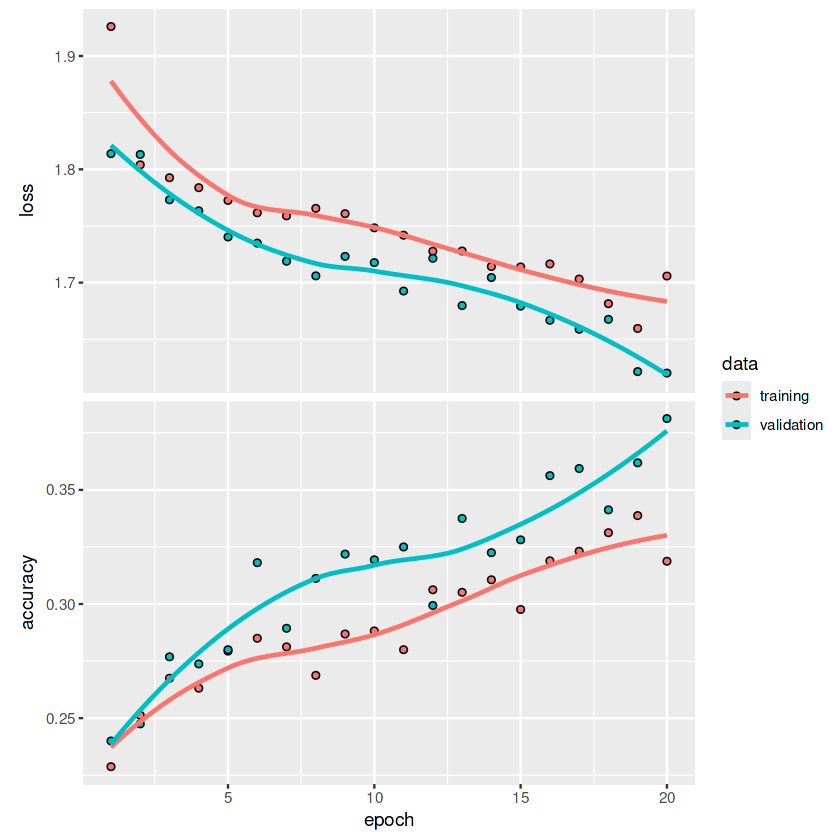

In [112]:
plot(history_ssdr)

In [114]:
test_generator <- flow_images_from_directory(
test_dir,
test_datagen,
target_size = c(150, 150),
batch_size = 20,
class_mode = "categorical",
color_mode = "grayscale"
)

ssdr_model %>% evaluate(test_generator, steps = 50)

loss accuracy 
1.572776 0.390000

In [115]:
# Save the trained SSDR model
ssdr_model %>% save_model_hdf5("ssdr_model.h5")


## Saving the Two models as tensflow lite for deployment

In [116]:
tf <- import("tensorflow")

In [117]:
cnn_converter <- tf$lite$TFLiteConverter$from_keras_model(cnn_model)
cnn_tflite_model <- cnn_converter$convert()

cnn_tflite_model_raw <- serialize(cnn_tflite_model, NULL)

cnn_tflite_path <- "cnn_model.tflite"
writeBin(cnn_tflite_model_raw, cnn_tflite_path)
cat("CNN Model has been converted and saved as 'cnn_model.tflite'.\n")

ssdr_converter <- tf$lite$TFLiteConverter$from_keras_model(ssdr_model)
ssdr_tflite_model <- ssdr_converter$convert()

ssdr_tflite_model_raw <- serialize(ssdr_tflite_model, NULL)

ssdr_tflite_path <- "ssdr_model.tflite"
writeBin(ssdr_tflite_model_raw, ssdr_tflite_path)
cat("SSDR Model has been converted and saved as 'ssdr_model.tflite'.\n")


CNN Model has been converted and saved as 'cnn_model.tflite'.
SSDR Model has been converted and saved as 'ssdr_model.tflite'.
